# Table of Contents
(_the TOC doesn't work in the GitHub viewer_)

* [Data Loading](#Data-Loading)
    * [Demography](#Demography)
    * [Test users](#Test-users)
* [Data Exploration](#Data-Exploration)
    * [Visualize demography](#Visualize-demography)
* [Features Engineering](#Features-Engineering)
    * [Extract potentialy useful features](#Extract-potentialy-useful-features)
    * [Explore features](#Explore-features)
    * [Dependencies between an age and each of featurtes](#Dependencies-between-an-age-and-each-of-featurtes)
    * [Create OLS metafeatures](#Create-OLS-metafeatures)
* [Predictions](#Predictions)
    * [Simple Models](#Simple-Models)
        * [Baseline (ols_total)](#Baseline-%28ols_total%29)
        * [Average TOP-10 OLS](#Average-TOP-10-OLS)
        * [Average TOP-5 OLS](#Average-TOP-5-OLS)
        * [Linear Regression TOP-10 OLS](#Linear-Regression-TOP-10-OLS)
    * [XGBoost](#XGBoost)
        * [XGBoost basic test (TOP-2 OLS)](#XGBoost-basic-test-%28TOP-2-OLS%29)
        * [XGBoost dirty test (all columns)](#XGBoost-dirty-test-%28all-columns%29)
        * [XGBoost OLS](#XGBoost-OLS)
        * [XGBoost OLS + Count](#XGBoost-OLS-+-Count)
        * [XGBoost All Features (tuned)](#XGBoost-All-Features-%28tuned%29)
    * [LightGBM](#LightGBM)
        * [LightGBM dirty test (all columns)](#LightGBM-dirty-test-%28all-columns%29)
        * [LightGBM OLS](#LightGBM-OLS)
        * [LightGBM OLS + Count](#LightGBM OLS-+-Count)
        * [LightGBM All Features (tuned)](#LightGBM-All-Features-%28tuned%29)
    * [Metamodels](#Metamodels)
        * [Simple Average (xgb, lgbm)](#Simple-Average-%28xgb,-lgbm%29)
        * [Linear Regression Average (xgb, lgbm)](#Linear-Regression-Average-%28xgb,-lgbm%29)
        * [Linear Regression Average (xgb, lgbm, ols)](#Linear-Regression-Average-%28xgb,-lgbm,-ols%29)
        * [Polynomial Regession Average (xgb, lgbm, ols)](#Polynomial-Regession-Average-%28xgb,-lgbm,-ols%29)
    * [Conclusion](#Conclusion)
        * [Final model full test predictions timing](#Final-model-full-test-predictions-timing)

In [42]:
import csv
import itertools
import os
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

SEED = 42
np.random.seed(SEED)

from lightgbm import LGBMRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from xgboost import cv, DMatrix, XGBRegressor

# Data Loading

In [2]:
TEST_USERS_FILE = 'users'
PART_PREFIX = 'part'
CACHED = 'cached'
DEMOGRAPHY_DIR = 'trainDemography'
GRAPH_DIR = 'graph'

### Demography

In [3]:
MAX_UID = !cat trainDemography/part* | cut -f1 | sort -n | tail -1
MAX_UID = int(MAX_UID[0])

In [4]:
%%time
demography_cache = os.path.join(DEMOGRAPHY_DIR, CACHED) + '.npy'
if os.path.isfile(demography_cache):
    demography_age = np.load(demography_cache)
else:
    demography_age = np.zeros(MAX_UID, np.int16)
    for filename in sorted(os.listdir(DEMOGRAPHY_DIR)):
        if not filename.startswith(PART_PREFIX):
            continue
        print(f'parse {filename}...')
        with open(os.path.join(DEMOGRAPHY_DIR, filename), 'r') as file:
            for uid, _, age, _, _, _, _, _ in csv.reader(file, delimiter='\t'):
                demography_age[int(uid) - 1] = 0 if age == '' else int(age)
        
    np.save(demography_cache, demography_age)

print(f'Loaded {demography_age.shape[0]} rows')
print(f'Size of demography data: {round(demography_age.nbytes / (1024 ** 2), 2)} MB')

Loaded 47289241 rows
Size of demography data: 90.2 MB
CPU times: user 0 ns, sys: 70 ms, total: 70 ms
Wall time: 261 ms


### Test users

In [5]:
%%time
test_uids = np.loadtxt(TEST_USERS_FILE, dtype=np.uint32)
print(f'Loaded {test_uids.shape[0]} rows')
print(f'Size of demography data: {round(test_uids.nbytes / (1024 ** 2), 2)} MB')

Loaded 43110 rows
Size of demography data: 0.16 MB
CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 163 ms


# Data Exploration

### Visualize demography

In [6]:
'''
The age is number of days since 1970-01-01
The `age // 365` is number of years since 1970
The `1970 + age // 365` is the year of birth
The `2017 - (1970 + age // 365) = 47 - age // 365` is the actual age of user
'''
age_pretty = pd.DataFrame(47 - demography_age // 365, dtype=np.int16, columns=['age'])
age_pretty.describe()

,age
count,4.728924e+07
mean,3.497816e+01
std,1.621590e+01
min,-4.000000e+01
25%,2.500000e+01
50%,3.200000e+01
75%,4.100000e+01
max,1.360000e+02


We can see some incorrect age.

[]

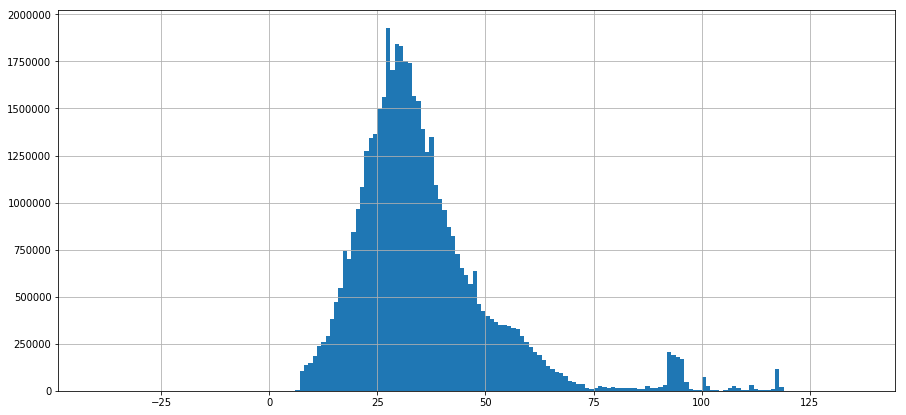

In [7]:
%matplotlib inline

age_pretty['age'].hist(bins=age_pretty['age'].max() - age_pretty['age'].min(), figsize=(15,7))
plt.plot()

The most of users have a correct age, but some one have a negative age or a very large age.  
Besides we can see a spike around 90 years. I don't believe it's a true age.  
Also we can see some kind of cap of min age.

**Find a min age cap**

[]

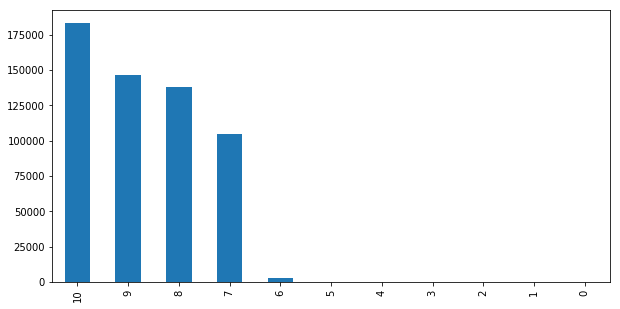

In [8]:
%matplotlib inline

age_pretty[age_pretty['age'].between(0,10)]['age'].value_counts().plot.bar(figsize=(10,5), color='C0')
plt.plot()

The min age cap is 6 years

**Remove age outliers behind 3σ and age below the cap**

In [9]:
%matplotlib inline

# Cut an incorrect data
clean_demography = age_pretty[age_pretty['age'] > 6]

# Remove outliers
age_mean = clean_demography['age'].mean()
age_std = clean_demography['age'].std()
outliers_filter = clean_demography['age'].between(age_mean - 3 * age_std, age_mean + 3 * age_std)
clean_demography = clean_demography[outliers_filter]

clean_demography.describe()

,age
count,4.595749e+07
mean,3.317459e+01
std,1.234076e+01
min,7.000000e+00
25%,2.500000e+01
50%,3.100000e+01
75%,4.000000e+01
max,8.300000e+01


We will use an age range between 7 and 83 years for feature engineering

**Visualize clean age**

[]

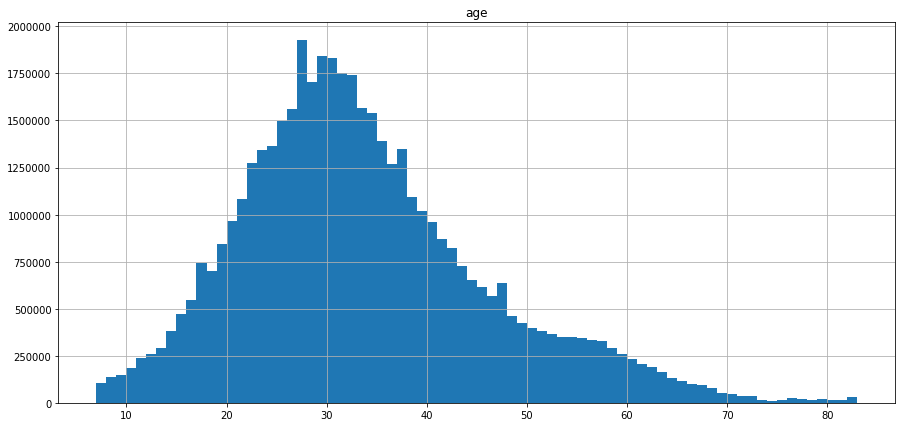

In [10]:
%matplotlib inline

clean_demography.hist(bins=clean_demography['age'].max() - clean_demography['age'].min(), figsize=(15,7))
plt.plot()

# Features Engineering

### Extract potentialy useful features

**Hypothesis #1**: The age of user depends on the age and type of his connections   
**Hypothesis #2**: (empirical observation) The number of connections of some types depends on the age of user. For example, older people have more collegues when yonger people have more friends  

So, we may split all connections to batches by type and calculate a median age (I believe it's more precise metric  than a mean for our purposes), a mean age (because we can, but very often mean perform better than median, I don't know why) and a number of connections (because hypothesis #2)

**Calculate age bounds**

In [11]:
# The bounds are inverted
MAX_AGE = (47 - 7) * 365  # 7 years old is the maximum number of days since 1970-01-01
MIN_AGE = (47 - 83) * 365  # 83 years old is the minimum number of days since 1970-01-01

**Calculate the number of users with known graph**

In [12]:
KNOWN_GRAPH = !cat graph/part* | wc -l
KNOWN_GRAPH = int(KNOWN_GRAPH[0])

**Extract features**

In [13]:
%%time

FEATURES_CACHE = 'features_cache'

if os.path.isfile(FEATURES_CACHE):
    features = pd.read_pickle(FEATURES_CACHE)
else:
    columns = ['uid', 'age', 'mean_total', 'median_total', 'count_total'] + [
        f'{t}_{rel}' for t, rel in itertools.product(('mean', 'median', 'count'), [str(2**i) for i in range(1,21)])
    ]

    features = pd.DataFrame()
    for column in columns:
        if column == 'uid':
            dtype = np.int32
        else:
            dtype = np.float32
        features[column] = np.zeros(KNOWN_GRAPH, dtype)
        
    columns_index = {}
    for column in columns:
        columns_index[column] = features.columns.get_loc(column)
        
    row_ptr = 0
    for filename in sorted(os.listdir(GRAPH_DIR)):
        if not filename.startswith(PART_PREFIX):
            continue
        print(f'parse {filename}...')
        with open(os.path.join(GRAPH_DIR, filename), 'r') as file:
            for uid, row in csv.reader(file, delimiter='\t'):
                age = demography_age[int(uid) - 1]
                
                if age < MIN_AGE or age > MAX_AGE:
                    continue  # Skip users with an incorrect age
                    
                features.iat[row_ptr, columns_index['uid']] = int(uid)
                features.iat[row_ptr, columns_index['age']] = age
                
                age_cache = defaultdict(list)
                for pair in row[1:-2].split('),'):
                    link_uid, mask = pair[1:].split(',')

                    mask = int(mask) & ~(1 << 0)
                    
                    if mask < 2 or mask > 2**21:
                        continue  # We can skip "zero" links

                    link_age = demography_age[int(link_uid) - 1]
                    
                    if link_age < MIN_AGE or link_age > MAX_AGE:
                        continue  # Skip users with incorrect age
                        
                    if link_age == 0 and np.isin(int(link_uid), test_uids):
                        continue  # Test users shouldn't be calculated in features

                    for b in range(1,21):
                        if (mask >> b) & 1:  
                            age_cache[str(2**b)].append(link_age)

                total_age = [v for l in age_cache.values() for v in l]
                if total_age:
                    features.iat[row_ptr, columns_index['mean_total']] = np.mean(total_age)
                    features.iat[row_ptr, columns_index['median_total']] = np.median(total_age)
                    features.iat[row_ptr, columns_index['count_total']] = len(total_age)
                    for mask, age_list in age_cache.items():
                        if not age_list:
                            continue  # Skip empty relations
                        features.iat[row_ptr, columns_index['mean_' + mask]] = np.mean(age_list)
                        features.iat[row_ptr, columns_index['median_' + mask]] = np.median(age_list)
                        features.iat[row_ptr, columns_index['count_' + mask]] = len(age_list)
                        
                row_ptr += 1
       
    features = features.set_index('uid')
    features = features.drop(0)
                
    features.to_pickle(FEATURES_CACHE)
              
print(f'Loaded {features.shape[0]} rows')
print(f'Size of features data: {round(sum(features.memory_usage()) / (1024 ** 2), 2)} MB')

Loaded 459004 rows
Size of features data: 115.56 MB
CPU times: user 30 ms, sys: 340 ms, total: 370 ms
Wall time: 592 ms


**Split features dataset**

In [14]:
features_train = features[~features.index.isin(test_uids)]
features_test = features[features.index.isin(test_uids)]
features_train.shape, features_test.shape

((415894, 64), (43110, 64))

### Explore features

In [15]:
relations = {
    2**1: 'Love',
    2**2: 'Spouse',
    2**3: 'Parent',
    2**4: 'Child',
    2**5: 'Brother/Sister',
    2**6: 'Uncle/Aunt',
    2**7: 'Relative',
    2**8: 'Close friend',
    2**9: 'Colleague',
    2**10: 'Schoolmate',
    2**11: 'Nephew',
    2**12: 'Grandparent',
    2**13: 'Grandchild',
    2**14: 'College/University fellow',
    2**15: 'Army fellow',
    2**16: 'Parent in law',
    2**17: 'Child in law',
    2**18: 'Godparent',
    2**19: 'Godchild',
    2**20: 'Playing together'
}

In [16]:
pd.set_option('display.max_columns', features_train.shape[1])
features_train.describe()                  

,age,mean_total,median_total,count_total,mean_2,mean_4,mean_8,mean_16,mean_32,mean_64,mean_128,mean_256,mean_512,mean_1024,mean_2048,mean_4096,mean_8192,mean_16384,mean_32768,mean_65536,mean_131072,mean_262144,mean_524288,mean_1048576,median_2,median_4,median_8,median_16,median_32,median_64,median_128,median_256,median_512,median_1024,median_2048,median_4096,median_8192,median_16384,median_32768,median_65536,median_131072,median_262144,median_524288,median_1048576,count_2,count_4,count_8,count_16,count_32,count_64,count_128,count_256,count_512,count_1024,count_2048,count_4096,count_8192,count_16384,count_32768,count_65536,count_131072,count_262144,count_524288,count_1048576
count,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000
mean,5386.020020,4521.265137,4833.447754,65.354279,179.602356,495.784027,-339.394562,1303.640015,3533.119873,118.690163,2628.334961,4093.071289,3115.283936,3752.612305,2851.464111,-166.450958,273.122742,2688.099365,1511.431030,234.748779,450.583862,188.995285,532.382080,418.078644,179.602249,495.784027,-339.429108,1304.096802,3569.688721,111.882317,2707.958008,4201.581543,3267.143311,3799.169922,2867.767578,-166.616150,273.778229,2724.544434,1539.997681,236.647995,452.097107,188.990112,533.385193,425.234558,0.033081,0.128319,0.218178,0.204749,3.992669,1.012272,2.969992,11.171061,21.085752,7.942269,0.906344,0.044862,0.045091,3.972791,3.625438,0.206411,0.139456,0.077972,0.086154,7.491421
std,4185.242676,3126.029053,3552.397461,210.859451,1195.161743,1790.291260,1774.789795,3509.914062,3973.721191,2982.946289,3585.828125,3978.767334,3517.282227,4043.975586,4494.129883,1246.618774,1772.650757,3750.680908,3452.793457,2031.541870,1806.587769,1592.012451,2294.551758,1928.931152,1195.161011,1790.291260,1774.782471,3512.699707,4040.460449,3030.366211,3716.595947,4137.397461,3672.349365,4136.399414,4524.511230,1248.306763,1777.173096,3806.584229,3522.759766,2049.035645,1812.879517,1591.976562,2299.042236,1964.802002,0.179062,0.334474,0.484800,0.882615,10.519276,2.085563,6.470133,44.568874,109.817963,22.432718,2.366862,0.305726,0.431504,13.941771,48.902977,0.822438,1.175676,0.287548,0.480351,112.524315
min,-13139.000000,-12967.000000,-12967.000000,0.000000,-13095.000000,-13139.000000,-13132.000000,-13075.000000,-13129.000000,-13138.000000,-13092.000000,-13129.000000,-13105.000000,-13119.000000,-13132.000000,-13137.000000,-12842.000000,-13137.000000,-13139.000000,-13087.000000,-13132.000000,-13135.000000,-13109.000000,-13091.000000,-13095.000000,-13139.000000,-13132.000000,-13075.000000,-13129.000000,-13138.000000,-13092.000000,-13129.000000,-13105.000000,-13119.000000,-13132.000000,-13137.000000,-12842.000000,-13137.000000,-13139.000000,-13087.000000,-13132.000000,-13135.000000,-13109.000000,-13091.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3366.000000,2446.883240,2481.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [17]:
pd.set_option('display.max_columns', features_test.shape[1])
features_test.describe()

,age,mean_total,median_total,count_total,mean_2,mean_4,mean_8,mean_16,mean_32,mean_64,mean_128,mean_256,mean_512,mean_1024,mean_2048,mean_4096,mean_8192,mean_16384,mean_32768,mean_65536,mean_131072,mean_262144,mean_524288,mean_1048576,median_2,median_4,median_8,median_16,median_32,median_64,median_128,median_256,median_512,median_1024,median_2048,median_4096,median_8192,median_16384,median_32768,median_65536,median_131072,median_262144,median_524288,median_1048576,count_2,count_4,count_8,count_16,count_32,count_64,count_128,count_256,count_512,count_1024,count_2048,count_4096,count_8192,count_16384,count_32768,count_65536,count_131072,count_262144,count_524288,count_1048576
count,43110.0,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000,43110.000000
mean,0.0,4529.738770,4844.508301,65.003548,188.586426,482.636597,-322.910278,1298.740356,3524.585205,136.109528,2612.398682,4100.759766,3122.046143,3744.582275,2844.145996,-159.649033,289.980133,2672.548584,1500.723511,246.427307,449.698639,175.101944,535.362488,428.815125,188.586426,482.636597,-323.147308,1299.874390,3562.636719,129.869537,2689.510010,4206.026367,3275.424072,3786.691650,2860.354004,-159.994125,291.316284,2711.257812,1529.213257,249.911713,450.488708,175.128754,536.885437,433.251038,0.033936,0.124565,0.212016,0.213779,4.034516,0.998191,2.950754,11.236558,20.931036,7.919462,0.911134,0.045326,0.055045,3.899026,3.640988,0.200673,0.139132,0.076850,0.086314,7.294247
std,0.0,3136.263184,3564.390137,214.416153,1221.848999,1766.209473,1778.273804,3502.809570,3981.968750,2973.642334,3594.742676,3998.114258,3519.801758,4054.760254,4491.884277,1233.332886,1810.050049,3751.568115,3446.130859,2035.240356,1812.477783,1569.389282,2298.918701,1941.288696,1221.848999,1766.209473,1778.675293,3506.500488,4052.041992,3021.616211,3729.111084,4160.178223,3674.453613,4146.956055,4521.953125,1235.661865,1817.261230,3809.399658,3516.138672,2052.958252,1817.841797,1569.410889,2303.863037,1975.530762,0.181324,0.330299,0.477283,1.769735,10.555427,2.007524,6.146620,44.445244,112.505127,23.053778,2.221975,0.320401,0.986752,13.587706,49.451721,0.847605,0.841156,0.289397,0.501727,114.027908
min,0.0,-12372.000000,-12372.000000,0.000000,-13059.000000,-13079.000000,-13086.000000,-12788.000000,-12962.000000,-12925.000000,-12745.000000,-12910.000000,-13096.000000,-12490.000000,-13117.000000,-13111.000000,-12931.000000,-13130.000000,-13139.000000,-12736.000000,-13047.000000,-12763.000000,-12574.000000,-13096.000000,-13059.000000,-13079.000000,-13086.000000,-12788.000000,-12962.000000,-12925.000000,-12745.000000,-12910.000000,-13096.000000,-12490.000000,-13117.000000,-13111.000000,-12931.000000,-13130.000000,-13139.000000,-12736.000000,-13047.000000,-12763.000000,-12574.000000,-13096.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,2432.747437,2438.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

[]

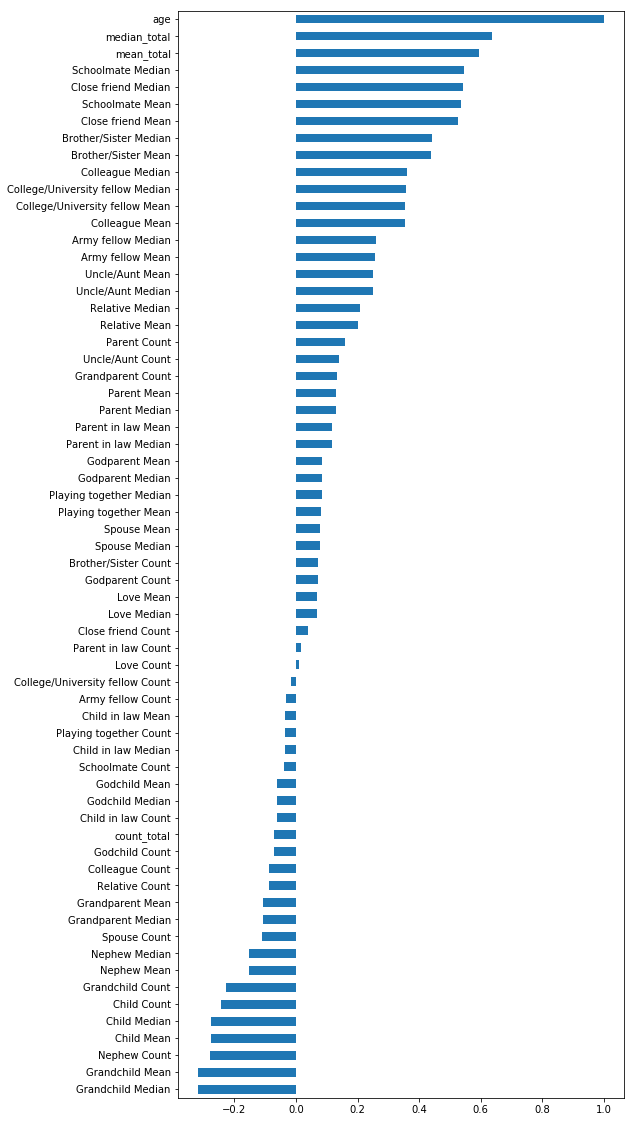

In [18]:
%matplotlib inline

features_train.rename(
    columns={f'mean_{mask}': f'{relations[mask]} Mean' for mask in [2**i for i in range(1,21)]}
).rename(
    columns={f'median_{mask}': f'{relations[mask]} Median' for mask in [2**i for i in range(1,21)]}
).rename(
    columns={f'count_{mask}': f'{relations[mask]} Count' for mask in [2**i for i in range(1,21)]}
).corrwith(features_train['age']).sort_values().plot.barh(figsize=(8,20), color='C0')
plt.plot()

### Dependencies between an age and each of featurtes

[]

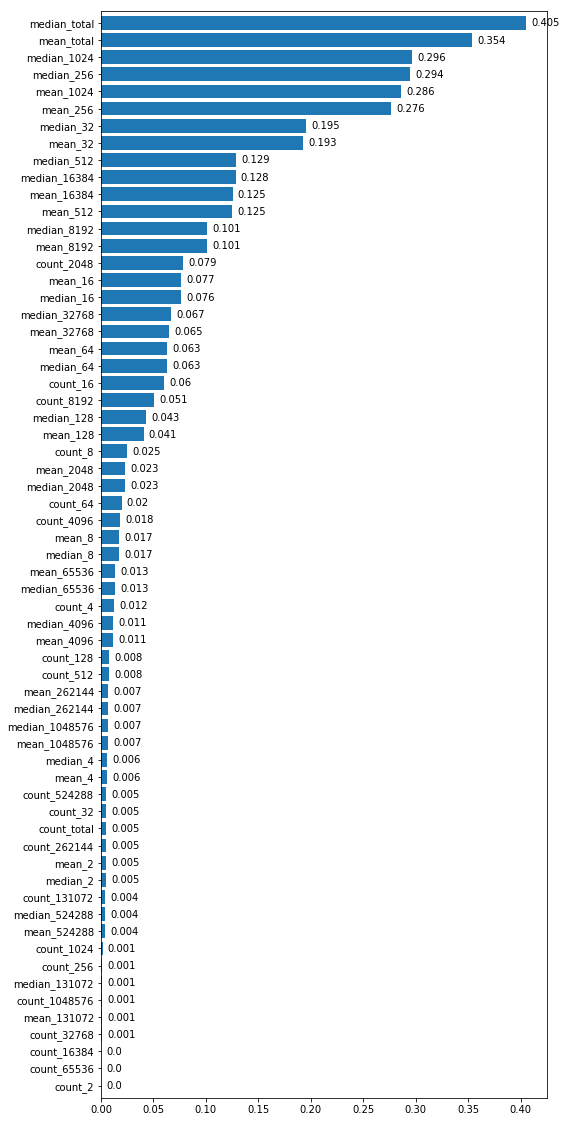

In [19]:
%matplotlib inline

r_squared = {}
ols_models = {}
for feature in features_train.columns:
    if feature == 'age':
        continue
        
    X = sm.add_constant(features_train[feature].values)
    model = sm.OLS(features_train['age'].values, X).fit()
    r_squared[feature] = model.rsquared
    ols_models[feature] = model

keys = []
r2 = []

for feature in sorted(r_squared, key=r_squared.get):
    keys.append(feature)
    r2.append(r_squared[feature])
    
fig, ax = plt.subplots(figsize=(8,20))
ax.barh(range(len(r2)), r2, align='center')
for i, v in enumerate(r2):
    ax.text(v + 0.005, i - 0.2, str(round(v,3)))
plt.yticks(range(len(r2)), keys)
plt.margins(y=0.005)

plt.plot()

Means and medians are important. I'll try to build sigle metafeature from them.

### Create OLS metafeatures

In [20]:
for mask in ['total'] + [str(2**i) for i in range(1,21)]:
    X_train = sm.add_constant(features_train[[f'mean_{mask}', f'median_{mask}']].values)
    X_test = sm.add_constant(features_test[[f'mean_{mask}', f'median_{mask}']].values)
    model = sm.OLS(features_train['age'].values, X_train).fit()
    features_train = features_train.assign(**{f'ols_{mask}': model.predict(X_train)})
    features_test = features_test.assign(**{f'ols_{mask}': model.predict(X_test)})
    
features_train.describe()

,age,mean_total,median_total,count_total,mean_2,mean_4,mean_8,mean_16,mean_32,mean_64,mean_128,mean_256,mean_512,mean_1024,mean_2048,mean_4096,mean_8192,mean_16384,mean_32768,mean_65536,mean_131072,mean_262144,mean_524288,mean_1048576,median_2,median_4,median_8,median_16,median_32,median_64,median_128,median_256,...,count_1024,count_2048,count_4096,count_8192,count_16384,count_32768,count_65536,count_131072,count_262144,count_524288,count_1048576,ols_total,ols_2,ols_4,ols_8,ols_16,ols_32,ols_64,ols_128,ols_256,ols_512,ols_1024,ols_2048,ols_4096,ols_8192,ols_16384,ols_32768,ols_65536,ols_131072,ols_262144,ols_524288,ols_1048576
count,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,...,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000,415894.000000
mean,5386.020020,4521.265137,4833.447754,65.354279,179.602356,495.784027,-339.394562,1303.640015,3533.119873,118.690163,2628.334961,4093.071289,3115.283936,3752.612305,2851.464111,-166.450958,273.122742,2688.099365,1511.431030,234.748779,450.583862,188.995285,532.382080,418.078644,179.602249,495.784027,-339.429108,1304.096802,3569.688721,111.882317,2707.958008,4201.581543,...,7.942269,0.906344,0.044862,0.045091,3.972791,3.625438,0.206411,0.139456,0.077972,0.086154,7.491421,5386.019909,5386.019909,5386.140406,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909,5386.019909
std,4185.242676,3126.029053,3552.397461,210.859451,1195.161743,1790.291260,1774.789795,3509.914062,3973.721191,2982.946289,3585.828125,3978.767334,3517.282227,4043.975586,4494.129883,1246.618774,1772.650757,3750.680908,3452.793457,2031.541870,1806.587769,1592.012451,2294.551758,1928.931152,1195.161011,1790.291260,1774.782471,3512.699707,4040.460449,3030.366211,3716.595947,4137.397461,...,22.432718,2.366862,0.305726,0.431504,13.941771,48.902977,0.822438,1.175676,0.287548,0.480351,112.524315,2688.410574,289.556934,330.167568,548.167228,1159.589527,1849.928570,1052.297727,868.517058,2278.620637,1503.027522,2283.385559,639.924760,444.619406,1330.140077,1501.645294,1083.546278,485.116935,155.383044,354.038642,253.621991,353.924913
min,-13139.000000,-12967.000000,-12967.000000,0.000000,-13095.000000,-13139.000000,-13132.000000,-13075.000000,-13129.000000,-13138.000000,-13092.000000,-13129.000000,-13105.000000,-13119.000000,-13132.000000,-13137.000000,-12842.000000,-13137.000000,-13139.000000,-13087.000000,-13132.000000,-13135.000000,-13109.000000,-13091.000000,-13095.000000,-13139.000000,-13132.000000,-13075.000000,-13129.000000,-13138.000000,-13092.000000,-13129.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11120.629787,2170.323347,2871.500000,1435.059937,993.790764,-2272.766861,731.129107,1498.994622,-4975.779437,-1345.688097,-5114.699889,3708.914577,127.526326,-5343.408738,-1533.166579,361.001009,2206.890606,2153.534864,2423.765860,2823.506144,2639.929730
25%,3366.000000,2446.883240,2481.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

[]

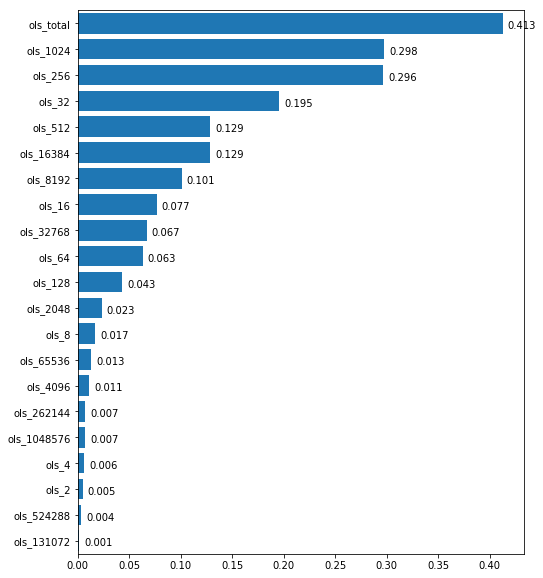

In [21]:
%matplotlib inline

r_squared = {}
for feature in features_train.columns:
    if not feature.startswith('ols'):
        continue
    X = sm.add_constant(features_train[feature].values)
    model = sm.OLS(features_train['age'].values, X).fit()
    r_squared[feature] = model.rsquared

keys = []
r2 = []

for feature in sorted(r_squared, key=r_squared.get):
    keys.append(feature)
    r2.append(r_squared[feature])
    
fig, ax = plt.subplots(figsize=(8,10))
ax.barh(range(len(r2)), r2, align='center')
for i, v in enumerate(r2):
    ax.text(v + 0.005, i - 0.2, str(round(v,3)))
plt.yticks(range(len(r2)), keys)
plt.margins(y=0.005)
plt.plot()

In [22]:
top_ols_features = sorted(r_squared, key=r_squared.get, reverse=True)[:10]
top_ols_features

['ols_total',
 'ols_1024',
 'ols_256',
 'ols_32',
 'ols_512',
 'ols_16384',
 'ols_8192',
 'ols_16',
 'ols_32768',
 'ols_64']

# Predictions

In [23]:
def save_submission(name, uids, pred):
    submission = pd.DataFrame({0: uids, 1: pred.astype(int)})
    submission.to_csv(f'submission_{name}.csv', sep=',', header=False, index=False)
    print(f'Saved: submission_{name}.csv')
    
def print_score(name, true_val, pred_val):
    print(f'{name}: {r2_score(true_val, pred_val)}')
    
def fit(model, X_train, y_train):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    print_score('train', features_train['age'], train_pred)

    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print('CV Score: min - %f, max - %f, mean - %f, std - %f' % (
        np.min(cv_score),
        np.max(cv_score),
        np.mean(cv_score),
        np.std(cv_score)
    ))

## Simple Models

### Baseline (ols_total)

In [24]:
print_score('train', features_train['age'], features_train['ols_total'])

pred = features_test['ols_total']
save_submission('baseline', features_test.index.values, pred)

train: 0.4126195836617135
Saved: submission_baseline.csv


### Average TOP-10 OLS

In [25]:
print_score('train', features_train['age'], features_train[top_ols_features].mean(axis=1))
save_submission('avg_ols_10', features_test.index.values, features_test[top_ols_features].mean(axis=1))

train: 0.28109404898860024
Saved: submission_avg_ols_10.csv


### Average TOP-5 OLS

In [26]:
print_score('train', features_train['age'], features_train[top_ols_features[:5]].mean(axis=1))
save_submission('avg_ols_10', features_test.index.values, features_test[top_ols_features[:5]].mean(axis=1))

train: 0.3577676363462804
Saved: submission_avg_ols_10.csv


### Linear Regression TOP-10 OLS
Note: We don't have to scale features because all of them are in the same scale

In [38]:
regressor = LinearRegression(n_jobs=6)
fit(regressor, features_train[top_ols_features], features_train['age'])
save_submission('lr_ols_10', features_test.index.values, regressor.predict(features_test[top_ols_features]))

train: 0.4847543560866
CV Score: min - 0.480374, max - 0.489969, mean - 0.484717, std - 0.003739
Saved: submission_lr_ols_10.csv


## XGBoost

### XGBoost basic test (TOP-2 OLS)

In [28]:
regressor = XGBRegressor(seed=SEED)

fit(regressor, features_train[['ols_total', 'ols_1024']], features_train['age'])
save_submission('xgb_basic', features_test.index.values, regressor.predict(features_test[['ols_total', 'ols_1024']]))

train: 0.5649155157722768
CV Score: min - 0.556813, max - 0.567941, mean - 0.563229, std - 0.004160
Saved: submission_xgb_basic.csv


### XGBoost dirty test (all columns)

In [29]:
regressor = XGBRegressor(seed=SEED)

columns = [col for col in features_train if col != 'age']

fit(regressor, features_train[columns], features_train['age'])
save_submission('xgb_dirty', features_test.index.values, regressor.predict(features_test[columns]))

train: 0.6365528232639643
CV Score: min - 0.628555, max - 0.639750, mean - 0.634471, std - 0.004634
Saved: submission_xgb_dirty.csv


### XGBoost OLS

In [30]:
regressor = XGBRegressor(seed=SEED)

columns = [col for col in features_train if col.startswith('ols')]

fit(regressor, features_train[columns], features_train['age'])
save_submission('xgb_ols', features_test.index.values, regressor.predict(features_test[columns]))

train: 0.6262729281114773
CV Score: min - 0.618120, max - 0.627011, mean - 0.623016, std - 0.004053
Saved: submission_xgb_ols.csv


### XGBoost OLS + Count

In [31]:
regressor = XGBRegressor(seed=SEED)

columns = [col for col in features_train if col.startswith('ols') or col.startswith('count')]

fit(regressor, features_train[columns], features_train['age'])
save_submission('xgb_ols_count', features_test.index.values, regressor.predict(features_test[columns]))

train: 0.6325540178820864
CV Score: min - 0.624165, max - 0.635386, mean - 0.630379, std - 0.004782
Saved: submission_xgb_ols_count.csv


**Check overfitting on the test set**

Dirty: 
- П: 273.3523599
- Ф: 274.4227012

OLS + Count: 
- П: 271.6161017
- Ф: 271.8057416

Okay, the full set of features works better

### XGBoost All Features (tuned)

In [32]:
xgb_model = XGBRegressor(learning_rate=0.2, max_depth=5, n_estimators=200, nthread=4, seed=SEED)

columns = [col for col in features_train if col != 'age']

fit(xgb_model, features_train[columns], features_train['age'])
save_submission('xgb_tuned', features_test.index.values, xgb_model.predict(features_test[columns]))

train: 0.6739926765088058
CV Score: min - 0.645885, max - 0.657232, mean - 0.652143, std - 0.004744
Saved: submission_xgb_tuned.csv


**XGBoost All Features (tuned)**

- П: 281.9309512
- Ф: 284.2822457

## LightGBM

### LightGBM dirty test (all columns)

In [43]:
regressor = LGBMRegressor(objective='regression', n_estimators=200, random_state=SEED)

columns = [col for col in features_train if col != 'age']

fit(regressor, features_train[columns], features_train['age'])
save_submission('lgbm_dirty', features_test.index.values, regressor.predict(features_test[columns]))

train: 0.6580896936911765
CV Score: min - 0.645652, max - 0.656505, mean - 0.651361, std - 0.004541
Saved: submission_lgbm_dirty.csv


### LightGBM OLS

In [44]:
regressor = LGBMRegressor(objective='regression', n_estimators=200, random_state=SEED)

columns = [col for col in features_train if col.startswith('ols')]

fit(regressor, features_train[columns], features_train['age'])
save_submission('lgbm_ols', features_test.index.values, regressor.predict(features_test[columns]))

train: 0.6502795712630701
CV Score: min - 0.638574, max - 0.649533, mean - 0.644599, std - 0.004897
Saved: submission_lgbm_ols.csv


### LightGBM OLS + Count

In [45]:
regressor = LGBMRegressor(objective='regression', n_estimators=200, random_state=SEED)

columns = [col for col in features_train if col.startswith('ols') or col.startswith('count')]

fit(regressor, features_train[columns], features_train['age'])
save_submission('lgbm_ols_count', features_test.index.values, regressor.predict(features_test[columns]))

train: 0.6543708442836597
CV Score: min - 0.641306, max - 0.652735, mean - 0.647829, std - 0.004794
Saved: submission_xgb_ols_count.csv


### LightGBM All Features (tuned)

In [49]:
lgbm_model = LGBMRegressor(objective='regression', num_leaves=120, learning_rate=0.05, 
                          n_estimators=250, random_state=SEED)

columns = [col for col in features_train if col != 'age']

fit(lgbm_model, features_train[columns], features_train['age'])
save_submission('lgbm_tuned', features_test.index.values, lgbm_model.predict(features_test[columns]))

train: 0.6828853957645293
CV Score: min - 0.651906, max - 0.663173, mean - 0.658126, std - 0.005053
Saved: submission_lgbm_tuned.csv


**LightGBM All Features (tuned)**
- П: 286.4427421
- Ф: 287.0881729

## Metamodels

### Simple Average (xgb, lgbm)

In [51]:
columns = [col for col in features_train if col != 'age']

avg_pred_train = pd.DataFrame({
    'xgb': xgb_model.predict(features_train[columns]),
    'lgbm': lgbm_model.predict(features_train[columns]),
}, index=features_train.index)
print_score('train', features_train['age'], avg_pred_train.mean(axis=1))

avg_pred_test = pd.DataFrame({
    'xgb': xgb_model.predict(features_test[columns]),
    'lgbm': lgbm_model.predict(features_test[columns]),
}, index=features_test.index)

save_submission('avg_xgb_lgbm', features_test.index.values, avg_pred_test.mean(axis=1))

train: 0.6806399634046503
Saved: submission_avg_xgb_lgbm.csv


### Linear Regression Average (xgb, lgbm)

In [53]:
columns = [col for col in features_train if col != 'age']

avg_pred_train = pd.DataFrame({
    'xgb': xgb_model.predict(features_train[columns]),
    'lgbm': lgbm_model.predict(features_train[columns]),
}, index=features_train.index)

regressor = LinearRegression()
fit(regressor, avg_pred_train, features_train['age'])

avg_pred_test = pd.DataFrame({
    'xgb': xgb_model.predict(features_test[columns]),
    'lgbm': lgbm_model.predict(features_test[columns]),
}, index=features_test.index)

save_submission('lr_xgb_lgbm', features_test.index.values, regressor.predict(avg_pred_test))

train: 0.6831225071665687
CV Score: min - 0.676955, max - 0.688195, mean - 0.683110, std - 0.004883
Saved: submission_lr_xgb_lgbm.csv


### Linear Regression Average (xgb, lgbm, ols)

In [58]:
columns = [col for col in features_train if col != 'age']

avg_pred_train = pd.DataFrame({
    'xgb': xgb_model.predict(features_train[columns]),
    'lgbm': lgbm_model.predict(features_train[columns]),
    'ols_total': features_train['ols_total']
}, index=features_train.index)

regressor = LinearRegression()
fit(regressor, avg_pred_train, features_train['age'])

avg_pred_test = pd.DataFrame({
    'xgb': xgb_model.predict(features_test[columns]),
    'lgbm': lgbm_model.predict(features_test[columns]),
    'ols_total': features_test['ols_total']
}, index=features_test.index)

save_submission('lr_xgb_lgbm_ols', features_test.index.values, regressor.predict(avg_pred_test))

train: 0.6836124022356902
CV Score: min - 0.677575, max - 0.688603, mean - 0.683598, std - 0.004839
Saved: submission_lr_xgb_lgbm_ols.csv


### Polynomial Regession Average (xgb, lgbm, ols)

In [70]:
columns = [col for col in features_train if col != 'age']

avg_pred_train = pd.DataFrame({
    'xgb': xgb_model.predict(features_train[columns]),
    'lgbm': lgbm_model.predict(features_train[columns]),
    'ols_total': features_train['ols_total']
}, index=features_train.index)

final_model = LinearRegression()
fit(final_model, PolynomialFeatures(degree=2).fit_transform(avg_pred_train), features_train['age'])

avg_pred_test = pd.DataFrame({
    'xgb': xgb_model.predict(features_test[columns]),
    'lgbm': lgbm_model.predict(features_test[columns]),
    'ols_total': features_test['ols_total']
}, index=features_test.index)

save_submission(
    'poly2_xgb_lgbm_ols', 
    features_test.index.values, 
    final_model.predict(PolynomialFeatures(degree=2).fit_transform(avg_pred_test))
)

train: 0.6846974683523412
CV Score: min - 0.678357, max - 0.689662, mean - 0.684641, std - 0.004970
Saved: submission_poly2_xgb_lgbm_ols.csv


**Polynomial Regession Average (xgb, lgbm, ols)**
- П: 287.5676460
- Ф: 287.5496522

# Conclusion
My best solution is a polynomial regression over predictions of XGBBoost, LightGBM and OLS models.  
Result is the second place (at the moment) with `287.5496522` public score.  

It's too complex model for production systems (in terms of learning time), but contest is contest.  
Also, I think in real world we don't have to predict exact day and yearly precision will be enough and simpler for computations.

### Final model full test predictions timing

In [73]:
%%time

columns = [col for col in features_train if col != 'age']

avg_pred_test = pd.DataFrame({
    'xgb': xgb_model.predict(features_test[columns]),
    'lgbm': lgbm_model.predict(features_test[columns]),
    'ols_total': features_test['ols_total']
}, index=features_test.index)

t = final_model.predict(PolynomialFeatures(degree=2).fit_transform(avg_pred_test))

CPU times: user 1.93 s, sys: 0 ns, total: 1.93 s
Wall time: 578 ms
